In [184]:
from protein_ligand import PDBProtein, parse_sdf_file
# from reconstruct import reconstruct_from_generated
import numpy as np
import scipy.linalg
from PIL import Image, ImageDraw, ImageFont
import rdkit
from pymol import cmd
import sascorer

from rdkit import Chem, DataStructs
from rdkit.Chem import SDWriter, Descriptors, Draw, QED, rdFingerprintGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import shutil
from tqdm import tqdm
import os

In [6]:
lig_path = './outputs/fin_files/4.sdf'
pro_path = './outputs/fin_files/4.pdb'

In [4]:
lig_dict = parse_sdf_file(lig_path)
lig_dict

{'element': array([ 6,  6,  6,  6,  6,  6, 17, 17,  6,  6,  6,  6, 17,  8,  8]),
 'pos': array([[  4.904,  -9.528,  21.742],
        [  5.124, -10.913,  21.146],
        [  3.78 , -11.582,  20.882],
        [  2.43 , -10.482,  21.332],
        [  2.88 ,  -9.282,  21.932],
        [  4.004,  -8.628,  22.042],
        [  1.13 , -10.032,  21.682],
        [  2.63 , -12.482,  20.432],
        [  3.254,  -7.228,  22.842],
        [  1.954,  -6.528,  23.092],
        [  0.654,  -6.528,  23.142],
        [ -0.196,  -7.378,  22.642],
        [ -0.696,  -8.528,  22.292],
        [  1.354,  -5.478,  23.592],
        [  4.904,  -6.528,  22.992]], dtype=float32),
 'bond_index': array([[ 0,  0,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,
          7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 13, 14],
        [ 1,  5,  0,  2,  1,  3,  7,  2,  4,  6,  3,  5,  0,  4,  8,  3,
          2,  5,  9, 14,  8, 10, 13,  9, 11, 10, 12, 11,  9,  8]]),
 'bond_type': array([2, 1, 2, 1, 1, 2, 1, 2, 1

In [7]:
pro_dict = PDBProtein(pro_path).to_dict_atom()
pro_dict

{'element': array([ 7,  6,  6,  8,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  7,  6,
         6,  8,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         7,  6,  6,  8,  6,  6,  6,  8,  7,  1,  1,  1,  1,  1,  1,  1,  1,
         7,  6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  7,  6,  6,  8,  6,  6,  6,  8,  8,  1,  1,  1,  1,  1,
         1,  7,  6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  7,  6,  6,  8,  6,  8,  6,  1,  1,  1,  1,  1,  1,
         1,  7,  6,  6,  8,  6,  6,  7,  6,  6,  7,  1,  1,  1,  1,  1,  1,
         7,  6,  6,  8,  6,  6,  6,  8,  8,  1,  1,  1,  1,  1,  1,  7,  6,
         6,  8,  6,  6,  6,  8,  8,  1,  1,  1,  1,  1,  1,  7,  6,  6,  8,
         6,  6,  6,  6,  6,  6,  6,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         7,  6,  6,  8,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  7,  6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  1,  1,  1,  1,
 

In [8]:
newmol = next(iter(Chem.SDMolSupplier(lig_path)))
rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(newmol, newmol)

with SDWriter('./outputs/tmp.sdf') as w:
    w.write(newmol)

In [11]:
np.mean(pro_dict['pos'],axis=0)

array([ 2.7129881, -7.5111356, 20.326757 ], dtype=float32)

In [42]:
os.system("obabel ./outputs/docking/4l.sdf \-O 4l.pdb")

1

In [172]:
data_path = '../../../../data/processed_2/'
crossdocked_path = '../../../../data/crossdocked/crossdocked_pocket10/crossdocked_pocket10/'

vina_dock = 'vina --receptor protein.pdbqt --ligand %s --center_x %.4f --center_y %.4f --center_z %.4f --size_x 40 --size_y 40 --size_z 40 --out %s'
vina_score = 'vina --receptor %s --ligand %s --score_only --log %s'

prepare_ligand = "C:\Python27\python.exe \"C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\\Utilities24\prepare_ligand4.py\" -l %s -v -o %s"# -A bonds_hydrogens"
prepare_protein = "C:\Python27\python.exe \"C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\\Utilities24\prepare_receptor4.py\" -r %s -o %s"# -A bonds_hydrogens"
pdbqt_to_pdb = "C:\Python27\python.exe \"C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\\Utilities24\pdbqt_to_pdb.py\" -f %s -o %s"


def load_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [173]:
print(prepare_ligand % ("ligand"+str(1)+".pdb", "ligand"+str(1)+".pdbqt"))
print(prepare_protein % ("protein"+str(1)+".pdb", "protein"+str(1)+".pdbqt"))
print(vina_score % ("protein.pdbqt","ligand.pdbqt", "log.txt"))
print(vina_dock % ("2.pdbqt", 1.3, 1.4, 1.5,"1.pdbqt"))
print(pdbqt_to_pdb % ("in.pdbqt", "out.pdb"))

C:\Python27\python.exe "C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\Utilities24\prepare_ligand4.py" -l ligand1.pdb -v -o ligand1.pdbqt
C:\Python27\python.exe "C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\Utilities24\prepare_receptor4.py" -r protein1.pdb -o protein1.pdbqt
vina --receptor protein.pdbqt --ligand ligand.pdbqt --score_only --log log.txt
vina --receptor protein.pdbqt --ligand 2.pdbqt --center_x 1.3000 --center_y 1.4000 --center_z 1.5000 --size_x 40 --size_y 40 --size_z 40 --out 1.pdbqt
C:\Python27\python.exe "C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\Utilities24\pdbqt_to_pdb.py" -f in.pdbqt -o out.pdb


In [82]:
index = load_file(data_path+'index.pickle')
sample_protein_ligand = load_file(data_path+index[0])

pfdim = len(sample_protein_ligand['pf'][0])
lfdim = len(sample_protein_ligand['lf'][0])

In [84]:
res = {}
affinities = []
failed = 0

for i in tqdm(range(10)):
    
    pl = load_file(data_path+index[i])
    p_path = pl['p']
    l_path = pl['l']
    
    os.system("obabel %s -O %s" % (crossdocked_path+l_path, "ligand.pdb"))
    
    ligand_prep = prepare_ligand % ("ligand.pdb", "ligand.pdbqt")
    os.system(ligand_prep)
    
    protein_prep = prepare_protein % (crossdocked_path+p_path, "protein.pdbqt")
    os.system(protein_prep)
    
    score_cmd = vina_score % ("protein.pdbqt","ligand.pdbqt", "log.txt")
    os.system(score_cmd)
    
    try:
        with open('log.txt', 'r') as f: log = f.readlines()
        affinity = float(log[18].split(' ')[1])
        # print(affinity)
        affinities.append(affinity)
    except:
        failed += 1
        pass
    
res['data'] = affinities
res['failed'] = failed
with open('affinities.obj', 'wb') as f: pickle.dump(res,f)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


In [66]:
with open('affinities.obj', 'rb') as f: dat = pickle.load(f)
dat['data'][:10], dat['failed']

([-5.27555,
  -7.74218,
  -4.88419,
  -4.82947,
  -3.95088,
  -4.64077,
  -7.91338,
  -4.86795,
  -7.65692,
  -7.61804],
 2743)

In [67]:
affs = np.array(dat['data'])

-7.42539078298153


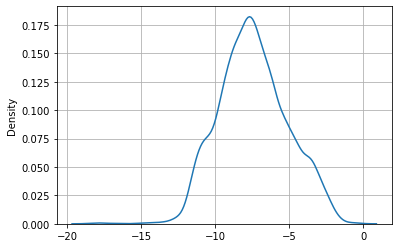

In [69]:
sns.kdeplot(data=affs[affs<0])
plt.grid()
print(np.mean(affs[affs<0]))

In [50]:
mol_data = []
with open('../outputs_planar_1/res.txt', 'r') as f:
    mol_data = f.readlines()

mol_data = [ x.strip().split(' ') for x in mol_data ]
mol_data = [ x[-2:] for x in mol_data ]
mol_data = mol_data[1:]
len(mol_data), mol_data[:5]

(1000,
 [['DPO1_BACCA_292_877_0/2hhw_A_rec_3px6_dct_lig_tt_docked_3_pocket10.pdb',
   'DPO1_BACCA_292_877_0/2hhw_A_rec_3px6_dct_lig_tt_docked_3.sdf'],
  ['BAZ2B_HUMAN_2053_2168_0/4ir3_A_rec_5cue_54y_lig_tt_min_0_pocket10.pdb',
   'BAZ2B_HUMAN_2053_2168_0/4ir3_A_rec_5cue_54y_lig_tt_min_0.sdf'],
  ['BRD4_HUMAN_42_168_0/4bw3_A_rec_4o72_2r4_lig_tt_min_0_pocket10.pdb',
   'BRD4_HUMAN_42_168_0/4bw3_A_rec_4o72_2r4_lig_tt_min_0.sdf'],
  ['CCPR_YEAST_69_361_0/5u60_A_rec_4jqk_1ln_lig_tt_min_0_pocket10.pdb',
   'CCPR_YEAST_69_361_0/5u60_A_rec_4jqk_1ln_lig_tt_min_0.sdf'],
  ['ANDR_HUMAN_666_919_ligBind_0/2ax8_A_rec_5t8e_77u_lig_tt_docked_0_pocket10.pdb',
   'ANDR_HUMAN_666_919_ligBind_0/2ax8_A_rec_5t8e_77u_lig_tt_docked_0.sdf']])

In [174]:
model_affinities = []
failed = 0
model_max_affinities = [] 

for i in tqdm(range(1000)):
    
    p_path = mol_data[i][0]
    data_l_path = mol_data[i][1] 
    l_path = "../mxQED_planar_1/"+str(i)+".sdf"
    
    # l_dict = parse_sdf_file(l_path)
    # l_center = np.mean(l_dict['pos'], axis=0)
    # print(l_center)
    
    pro_dict = PDBProtein(crossdocked_path+p_path).to_dict_atom()
    pro_center = np.mean(pro_dict['pos'],axis=0)
    
    try: shutil.copy(l_path, "ligand.sdf")
    except:
        failed += 1
        model_affinities.append(-1)
        model_max_affinities.append(-1)
        continue
    
    newmol = next(iter(Chem.SDMolSupplier("ligand.sdf")))
    rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(newmol, newmol)
    with SDWriter('planar_ligand.sdf') as w: w.write(newmol)
        
    protein_prep = prepare_protein % (crossdocked_path+p_path, "protein.pdbqt")
    x1 = os.system(protein_prep)
    
    x2 = os.system("obabel %s -O %s" % ("ligand.sdf", "ligand.pdb"))
    x3 = os.system("obabel %s -O %s" % ("planar_ligand.sdf", "planar_ligand.pdb"))
    
    ligand_prep = prepare_ligand % ("ligand.pdb", "ligand.pdbqt")
    planar_ligand_prep = prepare_ligand % ("planar_ligand.pdb", "planar_ligand.pdbqt")
    x4 = os.system(ligand_prep)
    x5 = os.system(planar_ligand_prep)
    
    score_cmd = vina_score % ("protein.pdbqt","ligand.pdbqt", "log.txt")
    x6 = os.system(score_cmd)
    
    dock_cmd = vina_dock % ("planar_ligand.pdbqt", pro_center[0], pro_center[1], pro_center[2], "result.pdbqt") 
    x7 = os.system(dock_cmd)
    
    # print(dock_cmd)
        
    # print(x1,x2,x3,x4,x5,x6,x7)
    
    if(x1 or x2 or x4 or x6 or x7):
        failed += 1
        model_affinities.append(-1)
        model_max_affinities.append(-1)
        continue
    
    try:
        with open('log.txt', 'r') as f: log = f.readlines()
        affinity = float(log[18].split(' ')[1])
        # print(affinity)
        
        with open("result.pdbqt", 'r') as f: log = f.readlines()
        max_affinity = float(log[1].split()[3])
        # print(max_affinity)
        
        model_affinities.append(affinity)
        model_max_affinities.append(max_affinity)
        
        os.system("vina_split --input result.pdbqt --ligand out")
        os.system(pdbqt_to_pdb % ("out1.pdbqt", "out_ligand.pdb"))
        os.system("obabel %s -O %s" % ("out_ligand.pdb", "./out/"+str(i)+".sdf"))
        
    except:
        failed += 1
        model_affinities.append(-1)
        model_max_affinities.append(-1)
        pass

 11%|████████▏                                                                    | 107/1000 [13:14<1:24:19,  5.67s/it][21:39:43] atom 3 has specified valence (1) smaller than the drawn valence 2.
[21:39:43] atom 7 has specified valence (1) smaller than the drawn valence 2.
 17%|█████████████▍                                                               | 174/1000 [20:54<1:56:22,  8.45s/it][21:47:23] atom 0 has specified valence (3) smaller than the drawn valence 4.
[21:47:23] atom 1 has specified valence (1) smaller than the drawn valence 2.
 20%|███████████████▍                                                             | 201/1000 [24:04<1:20:59,  6.08s/it][21:50:33] atom 0 has specified valence (3) smaller than the drawn valence 4.
[21:50:33] atom 2 has specified valence (1) smaller than the drawn valence 2.
 36%|████████████████████████████▊                                                  | 364/1000 [40:20<50:03,  4.72s/it][22:06:49] atom 16 has specified valence (3) smaller tha

In [203]:
res['model_affinities'] = list(model_affinities)
res['model_max_affinities'] = list(model_max_affinities)
with open('model_affinities.obj', 'wb') as f: pickle.dump(res,f)

In [207]:
with open('model_affinities.obj', 'rb') as f: dat = pickle.load(f)
np.mean(dat['model_max_affinities'])

-4.1589

In [176]:
def generate_image(rdmol, filname):
    
    rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(rdmol, rdmol)
    pilimage = Draw.MolToImage(rdmol)

    # print(MolToSmiles(rdmol))

    # rdmol = AddHs(rdmol)
    # logp and qed are the same irrespective of hydrogen addition

    logp = (Descriptors.MolLogP(rdmol))
    qed = QED.qed(rdmol)
    # props = QED.properties(rdmol)
    sascore = sascorer.calculateScore(rdmol)

    res = Image.new(pilimage.mode, (300, 350), (255,255,255))
    res.paste(pilimage, (0, 50))

    I1 = ImageDraw.Draw(res)

    params = ("logp = %.2f QED = %.2f SA = %.2f" % (logp, qed, sascore))
    font = ImageFont.truetype("myfont.ttf", 15)
    # print(params)
    # Add Text to an image
    I1.text((40, 25), params, fill=(0, 0, 0), font=font)

    # Display edited image
    # res.save('./outputs/'+filname+'.png')
    return res, qed, sascore, logp

In [217]:
qeds = []
ns = []
failed = 0

for i in tqdm(range(1000)):
    try:
        mol = next(iter(Chem.SDMolSupplier('./out/'+str(i)+'.sdf')))
        rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(mol, mol)
        img, qed, sascore, logp = generate_image(mol, 'tmp')
        img.save("./out/"+str(i)+".png")
        qeds.append(qed)
        ns.append(mol.GetNumAtoms())
    except:
        failed += 1
        qeds.append(-1)
        ns.append(0)

print(failed)
qeds = np.array(qeds)
ns = np.array(ns)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s][00:20:18] Explicit valence for atom # 0 N, 4, is greater than permitted
[00:20:18] ERROR: Could not sanitize molecule ending on line 25
[00:20:18] ERROR: Explicit valence for atom # 0 N, 4, is greater than permitted
  2%|█▏                                                                              | 15/1000 [00:00<00:20, 47.45it/s][00:20:18] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:20:18] ERROR: Could not sanitize molecule ending on line 29
[00:20:18] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[00:20:18] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:20:18] ERROR: Could not sanitize molecule ending on line 45
[00:20:18] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[00:20:18] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:20:18] ERROR: Could not sanitize m

 39%|██████████████████████████████▉                                                | 392/1000 [00:08<00:12, 48.82it/s][00:20:26] Explicit valence for atom # 0 C, 5, is greater than permitted
[00:20:26] ERROR: Could not sanitize molecule ending on line 29
[00:20:26] ERROR: Explicit valence for atom # 0 C, 5, is greater than permitted
[00:20:26] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:20:26] ERROR: Could not sanitize molecule ending on line 32
[00:20:26] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
 44%|██████████████████████████████████▉                                            | 443/1000 [00:09<00:11, 49.61it/s][00:20:27] Explicit valence for atom # 2 C, 5, is greater than permitted
[00:20:27] ERROR: Could not sanitize molecule ending on line 25
[00:20:27] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[00:20:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[00:20:27] ERROR: Could not sanitize m

121


In [236]:
for i in range(10):
    print(model_max_affinities[np.argsort(model_max_affinities)[i]], qeds[np.argsort(model_max_affinities)[i]], np.argsort(model_max_affinities)[i])

-10.1 -1.0 68
-9.6 0.6498029224211205 436
-8.8 0.33636247494796273 416
-8.7 -1.0 999
-8.7 0.6998681972611449 381
-8.4 0.8243872140957811 106
-8.3 0.6371768800358374 779
-8.2 -1.0 888
-8.2 0.6830282233270848 647
-8.2 0.7084872886742328 447


In [279]:
for i in tqdm(range(1000)):
    
    try:
#         cmd.reinitialize()
#         cmd.load(crossdocked_path+mol_data[i][0]) #"BXA1_CLOBO_2_425_0/5v8p_B_rec_4hev_axm_lig_tt_docked_3_pocket10.pdb")
#         cmd.set("cartoon_transparency", "0.5")
#         # cmd.load("../../data/crossdocked/crossdocked_pocket10/crossdocked_pocket10/"+mol_data[i][1]) #"BXA1_CLOBO_2_425_0/5v8p_B_rec_4hev_axm_lig_tt_docked_3_pocket10.pdb")
#         cmd.load("./out/"+str(i)+'.sdf')
#         cmd.reset()
#         cmd.png("out/"+str(i)+"pl.png")

#         cmd.reinitialize()
#         cmd.load(crossdocked_path+mol_data[i][0]) #"BXA1_CLOBO_2_425_0/5v8p_B_rec_4hev_axm_lig_tt_docked_3_pocket10.pdb")
#         cmd.png("out/"+str(i)+"p.png")
        
        cmd.reinitialize()
        cmd.load("./out/"+str(i)+'.sdf')
        cmd.reset()
        cmd.png("out/"+str(i)+"l.png")
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.12it/s]


In [241]:
model_max_affinities[46]

-7.0

In [285]:
for i in tqdm(range(1000)):
    
    if(qeds[i] == -1): continue
    if(model_max_affinities[i]>-6): continue
    if(ns[i] < 7): continue
    
    pl = Image.open("./out/"+str(i)+"pl.png")
    # print(pl.size)
    pl = pl.resize((448,336))
    l = Image.open("./out/"+str(i)+".png")
    # print(l.size)
    l = l.resize((288,336))
    p = Image.open("./out/"+str(i)+"p.png")
    p = p.resize((448,336))
    
    l3 = Image.open("./out/"+str(i)+"l.png")
    l3 = l3.resize((448,336))

    res = Image.new("RGB", (1184+448,336), (255,255,255))
    res.paste(p, (0,0))
    res.paste(l, (448,0))
    res.paste(l3, (448+288,0))
    res.paste(pl, (448+288+448,0))

    dr = ImageDraw.Draw(res)
    font = ImageFont.truetype("myfont.ttf", 15)
    score_text = "Vina Score : %.1f"%(model_max_affinities[i])
    dr.text((448+448+308,24), score_text, fill=(255, 255, 255), font=font)
    dr.text((25,24), "Receptor", fill=(255,255,255), font=font)
    dr.text((25+448+288,24), "Generated\nLigand", fill=(255,255,255), font=font)

    res.save('./out/res/'+str(i)+'.png')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.17it/s]


In [287]:
fin = Image.new("RGB", (1184+448,7*336), (255,255,255))
x = [46,71,72,106,297,347,350]
for i in range(7):
    tmp = Image.open("./out/res/"+str(x[i])+".png")
    fin.paste(tmp, (0, 336*i))
fin.save('fin.png')

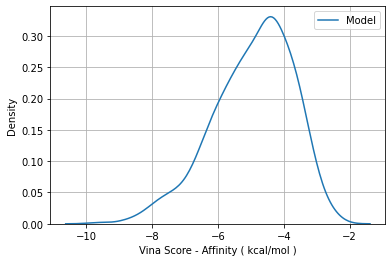

In [235]:
sns.kdeplot(data = model_max_affinities[(ns>=7)*(qeds!=-1)], label = "Model")
plt.xlabel("Vina Score - Affinity ( kcal/mol )")
plt.grid()
plt.legend()
plt.show()